## MET CS677 Data Science with Python - Assignment 3
### Alan Szmyt
#### Built with Python 3.10.6

In [1]:
!python --version

Python 3.10.6


In [2]:
# Python dependency imports.
import operator
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import Latex, SVG
from pandas import DataFrame, Series
from pathlib import Path
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    ConfusionMatrixDisplay
)
from assignment3 import (
    BankNote,
    bu_id_df,
    feature_stats_table,
    features_to_plot,
    knn_accuracy,
    log_reg_accuracy,
)
from utils import (
    create_latex_table,
    dataframe_memory_usage,
    artifacts,
    relative_path_to,
    rename_columns,
    resources,
    Color,
    save_figures,
    get_truth_statistics,
    get_truth_statistics_df,
    TruthStats,
)
from constants import (
    COL_CLASS,
    COL_COLOR,
    COL_F1,
    COL_F2,
    COL_F3,
    COL_F4,
    COL_PREDICTION,
    GOOD_BILLS,
    BANKNOTES,
    GOOD_BILLS_GREEN,
    FAKE_BILLS,
    FAKE_BILLS_RED,
    INITIAL_COLS,
    features_to_latex,
    stats_to_latex,
)

In [3]:
# Global Seaborn options.
sns.set_theme(font_scale=1.5, rc={"text.usetex": True})

# Global pandas options.
pd.set_option("display.max_rows", 10)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_seq_items", 50)
pd.set_option("display.show_dimensions", False)
pd.set_option("display.expand_frame_repr", False)
pd.set_option("mode.chained_assignment", "raise")
pd.set_option("display.precision", 4)
pd.set_option("styler.format.precision", 4)

cwd: Path = Path.cwd()

# Banknote dataset file from UCI.
banknote_dataset_file: Path = \
    resources.joinpath("data_banknote_authentication.txt")

print(
    f"Loading dataset from: "
    f"{relative_path_to(cwd, banknote_dataset_file)}"
)

Loading dataset from: resources/data_banknote_authentication.txt


In [4]:
# dtype mapping to use for the csv file. Set class to categorical.
dtypes = defaultdict(np.float64, {COL_CLASS: pd.CategoricalDtype.name})

# Loading the data_banknote_authentication.txt file into a dataframe.
banknote_dataset: DataFrame = pd.read_csv(
    banknote_dataset_file,
    header=None,
    names=INITIAL_COLS,
    dtype=dtypes
)

# Add color column to dataframe based upon the class column.
banknote_dataset[COL_COLOR] = banknote_dataset.apply(
    lambda row: Color.GREEN.lower
    if int(row[COL_CLASS]) == BankNote.LEGITIMATE
    else Color.RED.lower,
    axis=1
).astype("category")

# Build latex table to render in the document.
banknote_table = create_latex_table(
    rename_columns(banknote_dataset, features_to_latex).head(),
    label="tab:question1_1",
    caption="Question 1.1"
)
Latex(banknote_table)

<IPython.core.display.Latex object>

In [5]:
# Compute the feature distribution stats table.
feature_stats: DataFrame = feature_stats_table(
    banknote_dataset.drop(columns=COL_COLOR)
)

# Build latex table to render in the document.
banknote_stats_table = create_latex_table(
    rename_columns(feature_stats, stats_to_latex).head(),
    label="tab:question1_2",
    caption="Question 1.2"
)
Latex(banknote_stats_table)

<IPython.core.display.Latex object>

In [6]:
# Split the dataset into training/testing datasets split 50/50.
y: Series = banknote_dataset[COL_CLASS]
x_train, x_test, y_train, y_test = train_test_split(
    banknote_dataset,
    y,
    test_size=0.5, random_state=42, stratify=y
)

# Training subset of rows with legitimate banknotes.
train_good_bills: DataFrame = x_train.loc[
    x_train[COL_CLASS].astype(int) == BankNote.LEGITIMATE
]

# Training subset of rows with counterfeit banknotes.
train_bad_bills: DataFrame = x_train.loc[
    x_train[COL_CLASS].astype(int) == BankNote.COUNTERFEIT
]

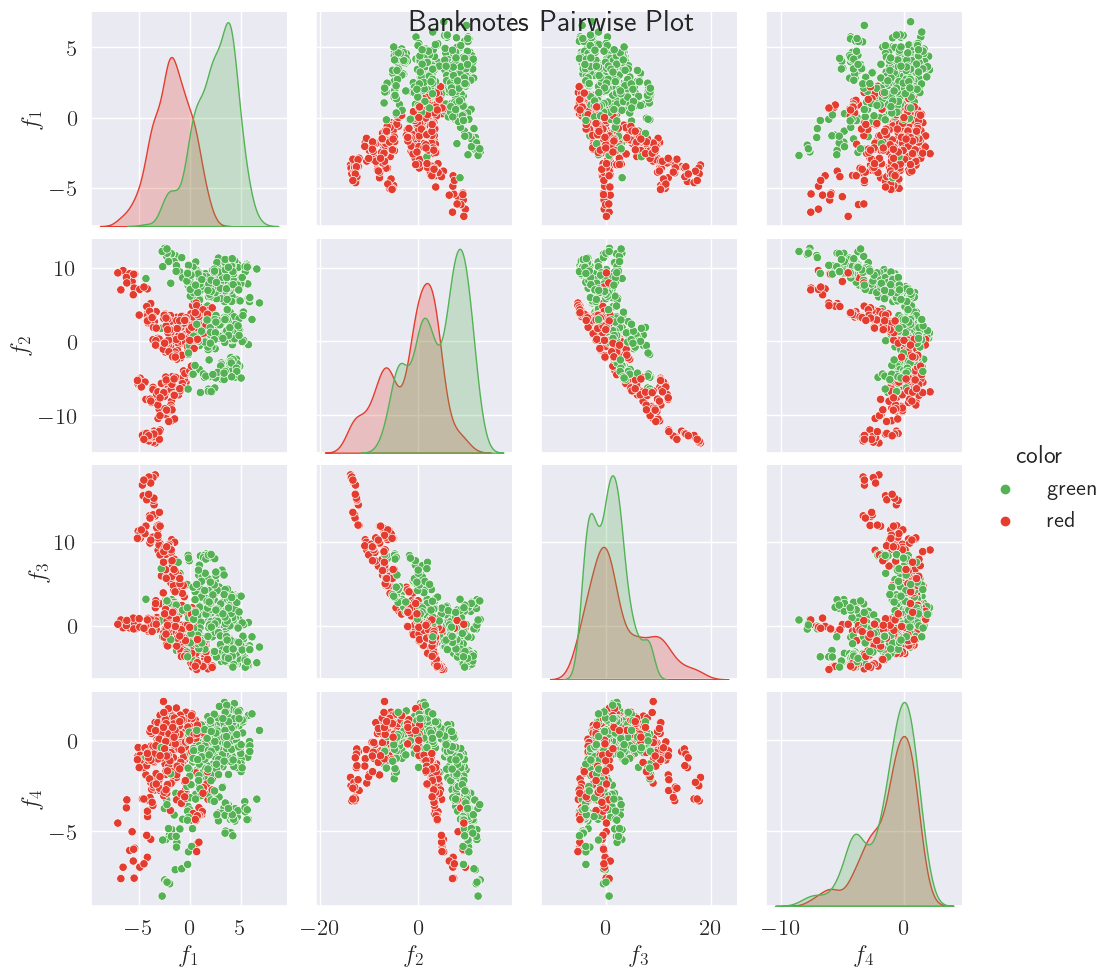

In [7]:
# Create, save, and plot a pairwise plot of the all bills.
train_pairwise = sns.pairplot(
    rename_columns(x_train, features_to_plot),
    hue="color",
    palette=[GOOD_BILLS_GREEN, FAKE_BILLS_RED],
)
train_pairwise.fig.suptitle("Banknotes Pairwise Plot")
plt.show()

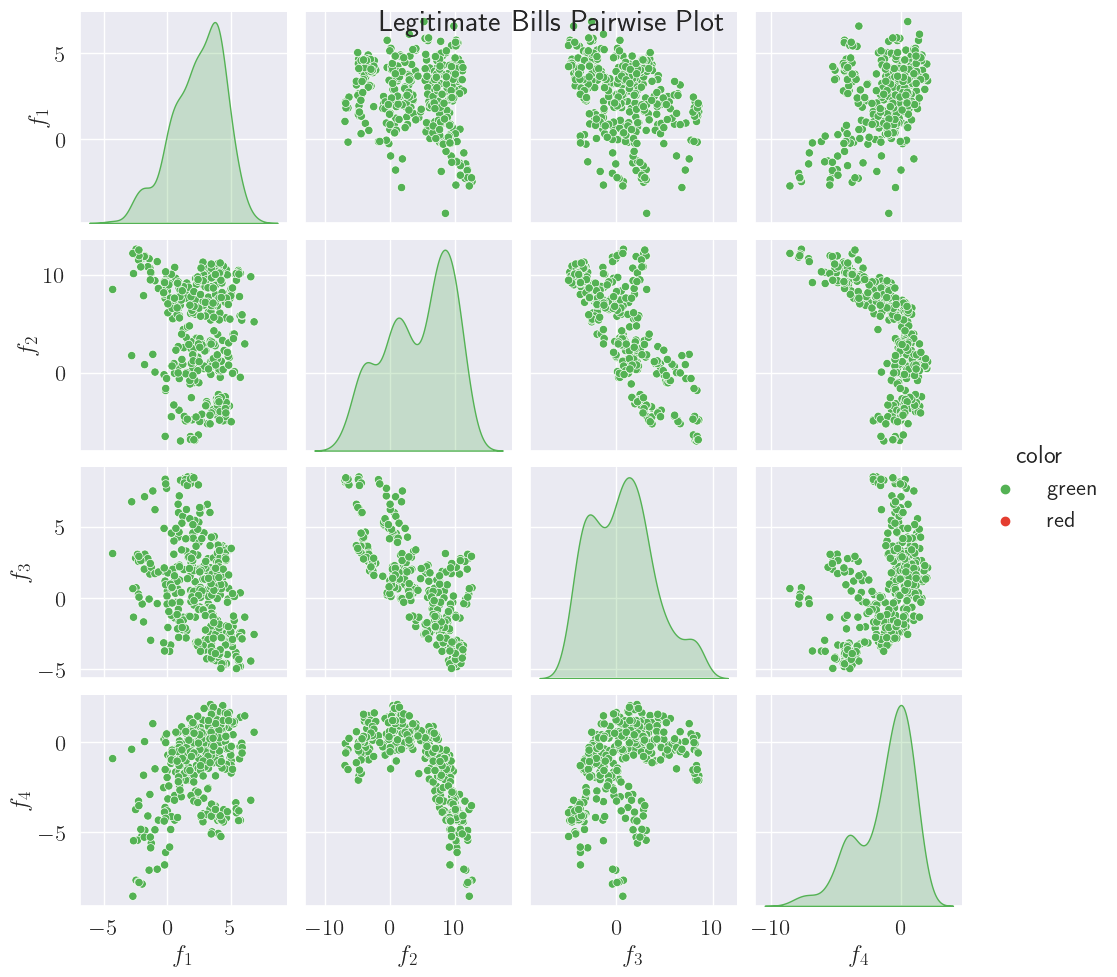

In [8]:
# Create, save, and plot a pairwise plot of the good bills.
good_pairwise = sns.pairplot(
    rename_columns(train_good_bills, features_to_plot),
    hue="color",
    palette=[GOOD_BILLS_GREEN, FAKE_BILLS_RED]
)
good_pairwise.fig.suptitle("Legitimate Bills Pairwise Plot")
plt.show()

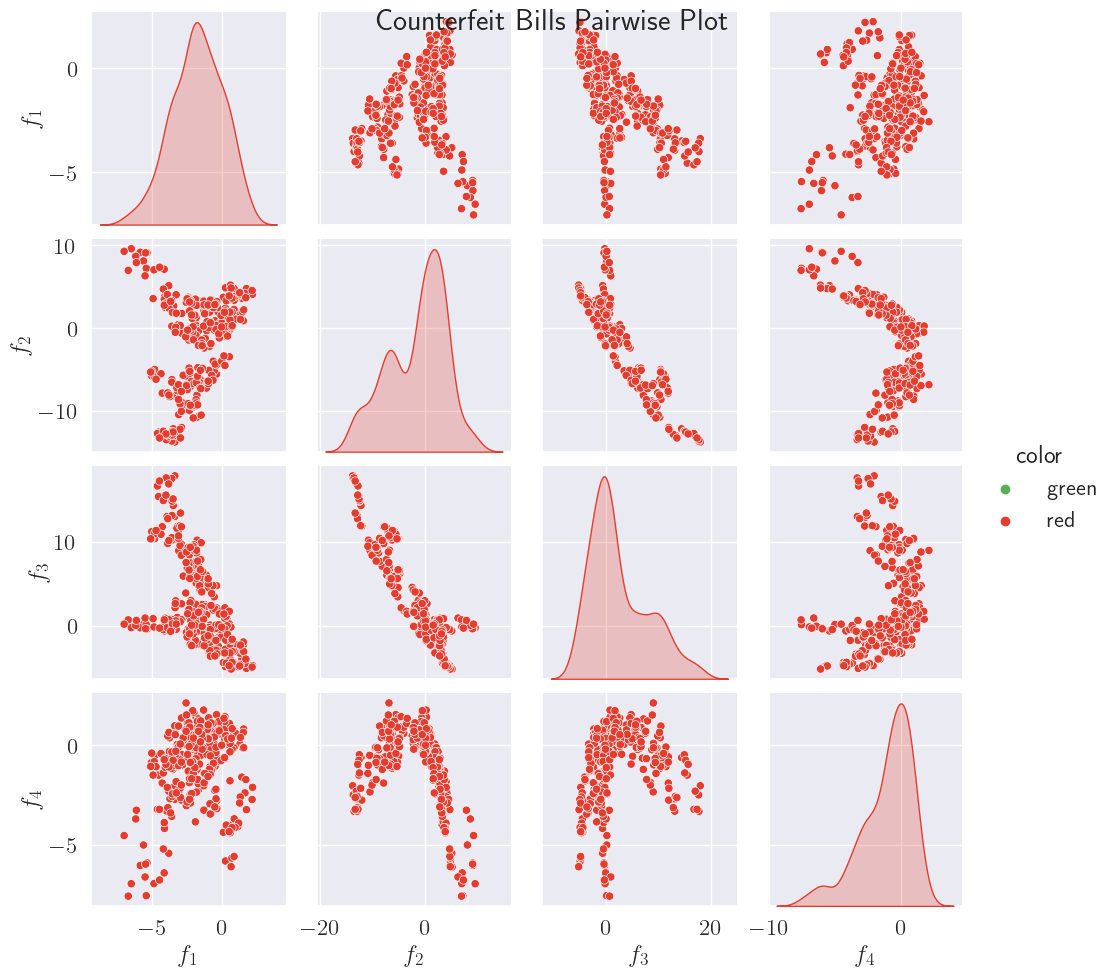

In [9]:
# Create, save, and plot a pairwise plot of the fake bills.
fake_pairwise = sns.pairplot(
    rename_columns(train_bad_bills, features_to_plot),
    hue="color",
    palette=[GOOD_BILLS_GREEN, FAKE_BILLS_RED]
)
fake_pairwise.fig.suptitle("Counterfeit Bills Pairwise Plot")
plt.show()

In [10]:
def simple_classifier(row: Series) -> int:
    """Simple classifier to predict if banknotes are counterfeit or legitimate.

    Args:
        row (Series): The row of the dataframe to predict the class label for.

    Returns:
        int: 0 if the label is legitimate, 1 if the label is fake.
    """
    if row[COL_F1] < 4 and row[COL_F2] < 10 < row[COL_F3]:
        return BankNote.COUNTERFEIT.value
    else:
        return BankNote.LEGITIMATE.value

In [11]:
# Apply the simple classifier to predict class labels.
x_test[COL_PREDICTION] = x_test.apply(simple_classifier, axis=1)

In [12]:
# Compute the confusion matrix statistics for the simple classifier.
truth_statistics: DataFrame = get_truth_statistics(
    x_test, COL_CLASS, COL_PREDICTION
)

true_positives: int = \
    truth_statistics[TruthStats.TRUE_POSITIVE.value].iloc[0]
print(f"True positives: {true_positives}")

false_positives: int = \
    truth_statistics[TruthStats.FALSE_POSITIVE.value].iloc[0]
print(f"False positives: {false_positives}")

true_negatives: int = \
    truth_statistics[TruthStats.TRUE_NEGATIVE.value].iloc[0]
print(f"True negatives: {true_negatives}")

false_negatives: int = \
    truth_statistics[TruthStats.FALSE_NEGATIVE.value].iloc[0]
print(f"False negatives: {false_negatives}")

true_positive_rate: int = \
    truth_statistics[TruthStats.TRUE_POSITIVE_RATE.value].iloc[0]
print(f"True positive rate: {true_positive_rate}")

true_negative_rate: int = \
    truth_statistics[TruthStats.TRUE_NEGATIVE_RATE.value].iloc[0]
print(f"True negative rate: {true_negative_rate}")

True positives: 381
False positives: 278
True negatives: 27
False negatives: 0
True positive rate: 1.0
True negative rate: 0.08852459016393442


In [13]:
# Build latex truth statistics table to render in the document.
truth_statistics_table = create_latex_table(
    truth_statistics,
    label="tab:question2_5",
    caption="Question 2.5"
)
Latex(truth_statistics_table)

<IPython.core.display.Latex object>

In [14]:
# Is the simple classifier's accuracy is better than a coin flip?
simple_accuracy: float = \
    truth_statistics.iloc[0][TruthStats.ACCURACY.value] * 100
print(f"Simple classifier's accuracy: {simple_accuracy}")
if simple_accuracy >= 50:
    print("Accuracy for simple classifier is better than a coin flip!")
else:
    print("Accuracy for simple classifier is worse than a coin flip!")

Simple classifier's accuracy: 59.0
Accuracy for simple classifier is better than a coin flip!


In [15]:
# n_neighbor values to try with the kNN classifier.
k_vals: list[int] = list(range(3, 12, 2))

# Split the dataset into training/testing datasets split 50/50.
y: Series = banknote_dataset[COL_CLASS]
x_train, x_test, y_train, y_test = train_test_split(
    banknote_dataset.drop([COL_COLOR, COL_CLASS], axis=1),
    y,
    test_size=0.5, random_state=42, stratify=y
)

# Feature scaling, generally necessary for kNN.
scaler: StandardScaler = StandardScaler()
x_train_sc: np.ndarray = scaler.fit_transform(x_train)
x_test_sc: np.ndarray = scaler.transform(x_test)

# Save the accuracies for each n_neighbor value.
knn_accuracies: dict[int, float] = {}
knn_error: dict[int, float] = {}
for k_val in k_vals:
    # k-Nearest Neighbor classifier for classifying banknotes.
    classifier: KNeighborsClassifier = KNeighborsClassifier(
        n_neighbors=k_val, p=2, metric="euclidean"
    )
    classifier.fit(x_train_sc, y_train)

    # Use classifier to make predictions.
    y_pred: np.ndarray = classifier.predict(x_test_sc)

    # Compute the accuracy for k and save.
    knn_accuracies.update({k_val: accuracy_score(y_test, y_pred)})

    # Compute the error rate of k and save.
    # Reference: https://stackoverflow.com/a/62616556
    knn_error.update({k_val: np.mean(y_pred != y_test)})

for k_val, knn_acc in knn_accuracies.items():
    print(f"Prediction accuracy for k={k_val}: {knn_acc}")

Prediction accuracy for k=3: 1.0
Prediction accuracy for k=5: 1.0
Prediction accuracy for k=7: 1.0
Prediction accuracy for k=9: 1.0
Prediction accuracy for k=11: 0.9985422740524781


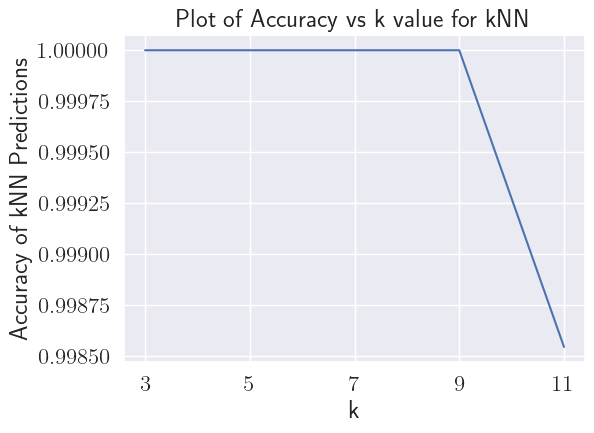

In [16]:
# Plot a graph showing the accuracies of each k.
plt.plot(k_vals, list(knn_accuracies.values()))
plt.xticks(k_vals)
plt.xlabel("k")
plt.ylabel("Accuracy of kNN Predictions")
plt.title("Plot of Accuracy vs k value for kNN")
plt.gcf().subplots_adjust(bottom=0.2, left=0.18)
plt.show()

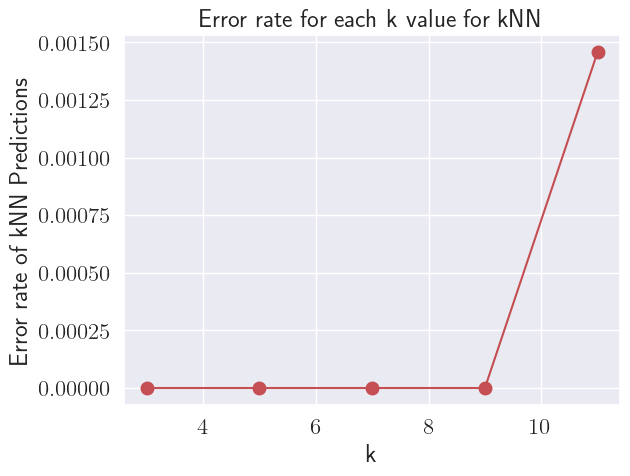

In [17]:
# Error rate plot.
plt.plot(k_vals, knn_error.values(), color="r", marker='o', markersize=9)
plt.xlabel("k")
plt.ylabel("Error rate of kNN Predictions")
plt.title("Error rate for each k value for kNN")
plt.show()

Selecting optimal k value as k=9.


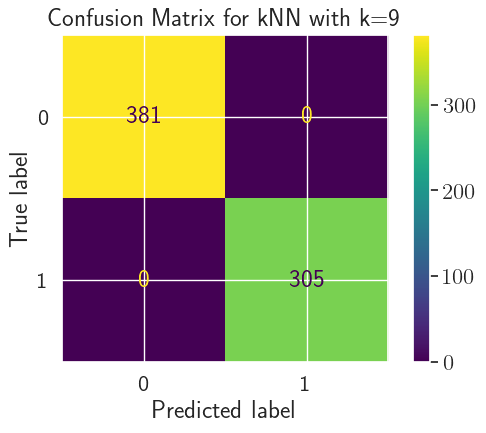

In [18]:
print("Selecting optimal k value as k=9.")

# Selecting k=9 to compute performance measures
classifier: KNeighborsClassifier = KNeighborsClassifier(
    n_neighbors=9, p=2, metric="euclidean"
)
classifier.fit(x_train_sc, y_train)
y_pred: np.ndarray = classifier.predict(x_test_sc)

# Create a confusion matrix to get metrics.
cm: np.array = confusion_matrix(y_test, y_pred)

# Create and show the confusion matrix plot.
disp: ConfusionMatrixDisplay = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.gcf().subplots_adjust(bottom=0.2)
plt.title("Confusion Matrix for kNN with k=9")
plt.show()

tn, fp, fn, tp = cm.ravel()

# Create a truth statistics table from kNN metrics.
knn_truth_statistics: DataFrame = get_truth_statistics_df(
    accuracy=accuracy_score(y_test, y_pred),
    true_positives=tp,
    false_positives=fp,
    true_negatives=tn,
    false_negatives=fn,
)

In [19]:
# Build latex knn truth statistics  table to render in the document.
knn_truth_statistics_table = create_latex_table(
    knn_truth_statistics,
    label="tab:question3_3",
    caption="Question 3.3"
)
Latex(knn_truth_statistics_table)

<IPython.core.display.Latex object>

In [20]:
# Scale this new dataset.
bu_test_sc: np.ndarray = scaler.transform(bu_id_df)
bu_pred_knn: np.ndarray = classifier.predict(bu_test_sc).astype(int)

bu_bill_knn: str = "legitimate" if bu_pred_knn == 0 else "counterfeit"
print(f"kNN predicted my BUID to be a {bu_bill_knn} banknote!")

bu_pred_simple = bu_id_df.apply(simple_classifier, axis=1).iloc[0]
bu_bill_simple: str = "legitimate" if bu_pred_simple == 0 else "counterfeit"
print(
    f"Simple classifier predicted my BUID"
    f" to be a {bu_bill_simple} banknote!"
)

kNN predicted my BUID to be a legitimate banknote!
Simple classifier predicted my BUID to be a legitimate banknote!


In [21]:
# Compute the accuracy with optimal k when each feature is missing.
k: int = 9
f1_missing_accuracy: float = knn_accuracy(
    x_train=x_train.drop([COL_F1], axis=1),
    x_test=x_test.drop([COL_F1], axis=1),
    y_train=y_train,
    y_test=y_test,
    k=k
)
print(
    f"kNN accuracy when f1 is missing "
    f"{f1_missing_accuracy}."
)

f2_missing_accuracy: float = knn_accuracy(
    x_train=x_train.drop([COL_F2], axis=1),
    x_test=x_test.drop([COL_F2], axis=1),
    y_train=y_train,
    y_test=y_test,
    k=k
)
print(
    f"kNN accuracy when f2 is missing "
    f"{f2_missing_accuracy}."
)

f3_missing_accuracy: float = knn_accuracy(
    x_train=x_train.drop([COL_F3], axis=1),
    x_test=x_test.drop([COL_F3], axis=1),
    y_train=y_train,
    y_test=y_test,
    k=k
)
print(
    f"kNN accuracy when f3 is missing "
    f"{f3_missing_accuracy}."
)

f4_missing_accuracy: float = knn_accuracy(
    x_train=x_train.drop([COL_F4], axis=1),
    x_test=x_test.drop([COL_F4], axis=1),
    y_train=y_train,
    y_test=y_test,
    k=k
)
print(
    f"kNN accuracy when f4 is missing "
    f"{f4_missing_accuracy}."
)

kNN accuracy when f1 is missing 0.9416909620991254.
kNN accuracy when f2 is missing 0.9664723032069971.
kNN accuracy when f3 is missing 0.9591836734693877.
kNN accuracy when f4 is missing 0.9985422740524781.


In [22]:
# Train on the dataset using logistic regression classifier.
logistic_regression: LogisticRegression = LogisticRegression()
logistic_regression.fit(x_train, y_train)
y_pred: np.ndarray = logistic_regression.predict(x_test)

log_reg_acc: float = accuracy_score(y_test, y_pred)

print(
    f"Accuracy for the logistic "
    f"regression classifier: {log_reg_acc}"
)

Accuracy for the logistic regression classifier: 0.9912536443148688


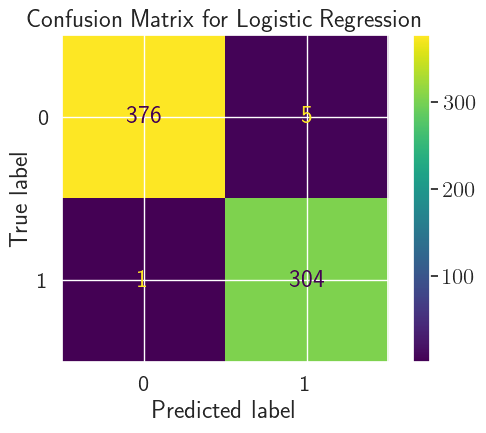

In [23]:
# Create a confusion matrix to get metrics.
cm: np.array = confusion_matrix(y_test, y_pred)

# Create and show the confusion matrix plot.
disp: ConfusionMatrixDisplay = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.gcf().subplots_adjust(bottom=0.2)
plt.title("Confusion Matrix for Logistic Regression")
save_figures("logistic_regression", artifacts)
plt.show()

In [24]:
# Get truth stats from confusion matrix.
tn, fp, fn, tp = cm.ravel()

# Create a truth statistics table from logistic regression metrics.
log_reg_truth_statistics: DataFrame = get_truth_statistics_df(
    accuracy=log_reg_acc,
    true_positives=tp,
    false_positives=fp,
    true_negatives=tn,
    false_negatives=fn,
)

# Build latex logistic regression truth statistics table to render in the document.
log_reg_truth_statistics_table = create_latex_table(
    log_reg_truth_statistics,
    label="tab:question5_2",
    caption="Question 5.2"
)
Latex(log_reg_truth_statistics_table)

<IPython.core.display.Latex object>

In [25]:
# Predict BUID using logistic regression.
bu_pred_log_reg: np.ndarray = logistic_regression.predict(bu_id_df).astype(int)

bu_bill_log_reg: str = \
    "legitimate" if bu_pred_log_reg == 0 else "counterfeit"
print(
    f"Logistic regression predicted my "
    f"BUID to be a {bu_bill_log_reg} banknote!"
)

Logistic regression predicted my BUID to be a legitimate banknote!


In [26]:
# Compute the accuracy with when each feature is missing.
f1_missing_accuracy: float = log_reg_accuracy(
    x_train=x_train.drop([COL_F1], axis=1),
    x_test=x_test.drop([COL_F1], axis=1),
    y_train=y_train,
    y_test=y_test,
)
print(
    f"logistic regression accuracy when f1 is missing "
    f"{f1_missing_accuracy}."
)

f2_missing_accuracy: float = log_reg_accuracy(
    x_train=x_train.drop([COL_F2], axis=1),
    x_test=x_test.drop([COL_F2], axis=1),
    y_train=y_train,
    y_test=y_test,
)
print(
    f"logistic regression when f2 is missing "
    f"{f2_missing_accuracy}."
)

f3_missing_accuracy: float = log_reg_accuracy(
    x_train=x_train.drop([COL_F3], axis=1),
    x_test=x_test.drop([COL_F3], axis=1),
    y_train=y_train,
    y_test=y_test,
)
print(
    f"logistic regression accuracy when f3 is missing "
    f"{f3_missing_accuracy}."
)

f4_missing_accuracy: float = log_reg_accuracy(
    x_train=x_train.drop([COL_F4], axis=1),
    x_test=x_test.drop([COL_F4], axis=1),
    y_train=y_train,
    y_test=y_test,
)
print(
    f"logistic regression accuracy when f4 is missing "
    f"{f4_missing_accuracy}."
)

logistic regression accuracy when f1 is missing 0.7988338192419825.
logistic regression when f2 is missing 0.9052478134110787.
logistic regression accuracy when f3 is missing 0.8760932944606414.
logistic regression accuracy when f4 is missing 0.9912536443148688.
